# Cooling Tower Data Analysis
### Importing necessary libraries

In [91]:
import pandas as pd
import numpy as np
from scipy.integrate import simps
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import seaborn as sns

## Data preprocessing
### Import and clean data
I had combined all the data from day 1 and added two columns, Group and Trial. These columns ended up being trivial as the liquid flow sufficed to group the data. I then aggregated by liquid flow and calculated means and standard deviations, compiling these values in a new dataframe.

In [ ]:
df = pd.read_csv("Cooling Tower Day 1 - All.csv")
df = df.drop(columns=['Group', 'Trial'])

### Units
|  | Set Point Temp | Gas Flow | Liquid Flow | Outlet Water | Inlet Water | Outlet Air - Dry Bulb | Outlet Air - Wet Bulb | Inlet Air - Wet Bulb | Inlet Air - Dry Bulb |
|--------|----------------|----------|-------------|--------------|-------------|-----------------------|-----------------------|----------------------|----------------------|
| Raw | $^\circ$ F | m/s | gal/min | $^\circ$ F | $^\circ$ F | $^\circ$ F | $^\circ$ F | $^\circ$ F | $^\circ$ F |
| Output | $^\circ$ C | kg/s | kg/s | $^\circ$ C | $^\circ$ C | $^\circ$ C | $^\circ$ C | $^\circ$ C | $^\circ$ C |

Most units can be readily converted to the desired output, with the exception of gas flow. Converting gas flow in m/s to kg/s requires the find the density of the inlet air, which is humid.

Perry's Guide: Find saturation vapor pressure pwb at wet-bulb temperature $T_{wb}$ from Eq. (12-4). Find actual vapor
pressure $p$ at dry-bulb temperature $T$ from psychrometer equation (12-11). Find mixing ratio $Y$ by
conversion from $p$ (Table 12-1).

**12-4:** $\ln p_s = − 6096.9385T^{−1} + 21.2409642 − 2.711193\times10^{−2}T + 1.673952\times10^{−5}T^2 + 2.433502 \ln T$

where $T$ is in Kelvin, $p_s$ is in pascals.

**12-11:** $p = p_{wb} − AP(T − T_{wb})$

where $A$ is the psychrometric coefficient and $P$ is atmosphere pressure.

**12-11a:** $A = 6.5\times10^{−4}(1 + 0.000944T_{wb})$

Eq. 12-11a is valid for $T_{wb}$ up to 30 $^\circ$C.

**Table 12-1**: $Y = \frac{0.622p}{P-p}$

where $P$ is atmospheric pressure i.e. what the barometer reads, and $Y$ is the absolute humidity (kg/kg).

From $Y$, air density is readily found.

In [ ]:
def McRae(T):
    # T = ambient temperature, Inlet Air - Dry Bulb
    t = lambda T: 1-373.15/T
    P

In [97]:
df1 = df.groupby(['Set Point Temp','Gas Flow', 'Liquid Flow']).agg('mean').reset_index(drop=True)
df2 = df.groupby(['Set Point Temp','Gas Flow', 'Liquid Flow']).agg('std').reset_index(drop=True)
df2 = df2.rename(lambda x: x+' - std', axis=1)
df = df[['Set Point Temp', 'Gas Flow', 'Liquid Flow']].drop_duplicates().reset_index()
df = pd.concat([df, df1, df2], axis=1).drop(columns='index')
df.head()

,Set Point Temp,Gas Flow,Liquid Flow,Outlet Water,Inlet Water,Outlet Air - Dry Bulb,Outlet Air - Wet Bulb,Inlet Air - Wet Bulb,Inlet Air - Dry Bulb,Outlet Water - std,Inlet Water - std,Outlet Air - Dry Bulb - std,Outlet Air - Wet Bulb - std,Inlet Air - Wet Bulb - std,Inlet Air - Dry Bulb - std
0,45,1.98,0.2,31.433333,45.633333,32.800000,31.733333,14.833333,20.500000,0.208167,0.152753,0.300000,0.208167,0.057735,0.100000
1,45,1.98,0.4,34.466667,45.500000,36.833333,35.833333,14.666667,20.566667,0.057735,0.100000,0.152753,0.057735,0.057735,0.057735
2,45,1.98,0.6,36.700000,46.533333,39.533333,39.066667,14.633333,20.633333,0.100000,0.057735,0.057735,0.057735,0.057735,0.152753
3,45,1.98,0.8,38.133333,47.500000,41.333333,41.000000,14.733333,20.400000,0.152753,0.100000,0.057735,0.100000,0.057735,0.100000
4,45,1.98,1.0,39.200000,45.566667,41.700000,41.333333,14.900000,20.566667,0.100000,0.057735,0.100000,0.057735,0.000000,0.152753


### General equations
Defined as many functions as possible. i.e. Those that won't change.
* $merkel$: Merkel equation, form that is readily integrated, i.e. instanteous evaluation
* $hsat$: Enthalpy of saturated air, form for fit equation

In [3]:
def merkel(T, delh):
    NTU = 4182/(delh)*T
    return NTU
def hsat(T, a, b):
    return a*np.exp(b*T)

### Fitting $hsat$ and plotting result

In [4]:
# Empirical/fit data
hs_T = [40, 50, 60, 70, 80, 90, 100, 110, 120, 130]
hs_h = [15.230, 20.301, 26.46, 34.09, 43.69, 55.93, 71.73, 92.34, 119.54, 155.9]

# Fitting procedure
hsat_fit, hsat_cov = curve_fit(hsat, hs_T, hs_h, [0, 0])
fit_err = np.sqrt(np.diagonal(hsat_cov))

# Get fitted curve
hs_Tdata = np.linspace(hs_T[0], hs_T[-1], 100)
hs_hdata = hsat(hs_Tdata, *hsat_fit)
hs_h_errp = hsat(hs_Tdata, *hsat_fit+fit_err)
hs_h_errn = hsat(hs_Tdata, *hsat_fit-fit_err)

[5.60899875 0.02553773]
[0.08637353 0.00013167]


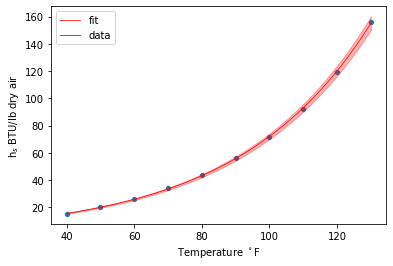

In [5]:
# Plot data and fitted curve
fig_hs, ax_hs = plt.subplots()
sns.scatterplot(hs_T, hs_h, ax=ax_hs)
sns.lineplot(hs_Tdata, hs_hdata, ax=ax_hs, color='r', size=10)
ax_hs.set(xlabel='Temperature $^\circ$F', ylabel='h$_s$ BTU/lb dry air')
ax_hs.fill_between(hs_Tdata, hs_h_errp, hs_h_errn, color='r', alpha=0.3)
plt.legend(labels=['fit', 'data'])
plt.show(ax_hs)

### Define air operating-line
Now that hsat is fitted, $enthalpy$ can be defined

In [6]:
def enthalpy(Tin, L, G, T, Tout):
    # Cp water = 4182 J/kg C
    # Tout = Cold-water temperature (Water out)
    # T = Wet bulb temperature out
    # Tin = Wet bulb temperature in
    hin = hsat(Tin, *hsat_fit)
    h = hin + L/G * 4182 * (T-Tout)
    return h

### Calculate Enthalpy and add to Dataframe

In [84]:
df['Enthalpy'] = df.apply(lambda x: enthalpy(x['Inlet Air - Wet Bulb'],
                            x['Liquid Flow'],
                            x['Gas Flow'],
                            x['Outlet Air - Wet Bulb'],
                            x['Outlet Water']
                           ),
         axis=1
        )

In [90]:
df.head()

,Set Point Temp,Gas Flow,Liquid Flow,Outlet Water,Inlet Water,Outlet Air - Dry Bulb,Outlet Air - Wet Bulb,Inlet Air - Wet Bulb,Inlet Air - Dry Bulb,Outlet Water - std,Inlet Water - std,Outlet Air - Dry Bulb - std,Outlet Air - Wet Bulb - std,Inlet Air - Wet Bulb - std,Inlet Air - Dry Bulb - std,Enthalpy
0,45,1.98,0.2,31.433333,45.633333,32.800000,31.733333,14.833333,20.500000,0.208167,0.152753,0.300000,0.208167,0.057735,0.100000,134.919467
1,45,1.98,0.4,34.466667,45.500000,36.833333,35.833333,14.666667,20.566667,0.057735,0.100000,0.152753,0.057735,0.057735,0.057735,1162.783663
2,45,1.98,0.6,36.700000,46.533333,39.533333,39.066667,14.633333,20.633333,0.100000,0.057735,0.057735,0.057735,0.057735,0.152753,3007.362581
3,45,1.98,0.8,38.133333,47.500000,41.333333,41.000000,14.733333,20.400000,0.152753,0.100000,0.057735,0.100000,0.057735,0.100000,4851.969280
4,45,1.98,1.0,39.200000,45.566667,41.700000,41.333333,14.900000,20.566667,0.100000,0.057735,0.100000,0.057735,0.000000,0.152753,4514.064740


In [100]:
df.iloc[8]

Set Point Temp                 45.000000
Gas Flow                        3.890000
Liquid Flow                     0.200000
Outlet Water                   25.866667
Inlet Water                    44.066667
Outlet Air - Dry Bulb          28.133333
Outlet Air - Wet Bulb          27.000000
Inlet Air - Wet Bulb           15.066667
Inlet Air - Dry Bulb           20.900000
Outlet Water - std              0.152753
Inlet Water  - std              0.057735
Outlet Air - Dry Bulb - std     0.057735
Outlet Air - Wet Bulb - std     0.100000
Inlet Air - Wet Bulb - std      0.152753
Inlet Air - Dry Bulb - std      0.000000
Name: 8, dtype: float64

In [ ]:
h_plots = plt.subplots(1, 3)
